1. Project Overview and Objectives

This project explores the intersection of Generative AI and the humanities through the task of sarcasm detection in German-language social media text. Sarcasm, as a pragmatic and culturally embedded linguistic phenomenon, poses a significant challenge for NLP systems because meaning often contradicts literal wording and relies on shared cultural knowledge, context, and perspective.

The primary technical objective is to fine-tune a DistilBERT transformer model on the German subset of the MultiPICo (Multilingual Perspectivist Irony Corpus) dataset to classify whether a sentence is sarcastic or non-sarcastic. Model performance is evaluated primarily using the F1-score, reflecting the class imbalance typical of sarcasm datasets.
From a humanistic perspective, the project investigates how AI systems handle linguistic variation, particularly differences between Standard German, Austrian German, and Swiss German, and reflects on how such systems may reinforce or mitigate cultural and dialectal biases when deployed in real-world applications such as sentiment analysis or content moderation.

2. Integrating AI with the Humanities
This work situates NLP not merely as a technical exercise but as a tool for cultural and linguistic inquiry. Social media platforms function as large-scale archives of human expression, where irony and sarcasm are frequently used to negotiate identity, critique power, and express emotion.
By operationalizing sarcasm detection, the project engages with core humanistic questions:
How do computational models interpret pragmatic meaning?
To what extent can models trained on dominant language varieties fairly represent marginalized dialects?
What is lost when nuanced human expression is reduced to binary labels?
The choice of the MultiPICo dataset is especially relevant here, as its annotations are provided by demographically diverse annotators, aligning with humanistic values of perspectivism and transparency. This allows the model to be trained not on a single authoritative interpretation of sarcasm, but on aggregated human judgments reflecting multiple viewpoints.

3. Methodology and Notebook Walkthrough

3.1 Data Loading and Exploration

The notebook begins by loading the MultiPICo dataset and filtering it to the relevant German-language samples. Initial exploratory analysis examines:

Class distribution (sarcastic vs. non-sarcastic)

Distribution across German language varieties

Dataset size and balance considerations

This step highlights an important linguistic reality: sarcasm is relatively rare compared to literal language, which motivates later methodological choices such as weighted loss functions.

3.2 Preprocessing and Tokenization

Text preprocessing is intentionally minimal to preserve linguistic signals such as punctuation, capitalization, and informal constructions, all of which may contribute to sarcastic meaning.

Tokenization is performed using the DistilBERT tokenizer, which:

Converts raw text into subword tokens

Applies padding and truncation to ensure uniform sequence lengths

Produces attention masks required by transformer models

This step demonstrates how human language is transformed into a numerical representation that the model can process, raising broader questions about what linguistic nuance may be preserved or lost in this transformation.

3.3 Model Initialization and Training

The core of the notebook initializes a pre-trained DistilBERT model and adapts it for binary sequence classification. DistilBERT is chosen as a compromise between:

Performance (strong contextual embeddings)

Efficiency (fewer parameters than BERT)

Training is conducted using supervised fine-tuning with:

Weighted cross-entropy loss to address class imbalance

Early stopping to prevent overfitting

Periodic evaluation on a validation set

These choices reflect methodological rigor and aim to ensure that performance gains are meaningful rather than artifacts of memorization.

3.4 Evaluation and Metrics

Model performance is evaluated primarily using the F1-score, which balances precision and recall and is well-suited for imbalanced classification tasks. Additional metrics such as accuracy and loss curves are used for diagnostic purposes.

Where possible, results are disaggregated by language variety to assess whether the model performs unevenly across Standard German, Austrian German, and Swiss German. This step directly connects technical evaluation with questions of linguistic fairness.

1. This cell imports all required Python libraries.

In [6]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import datasets
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    TrainingArguments, 
    Trainer,
    DistilBertTokenizer, 
    DistilBertModel,
    get_linear_schedule_with_warmup
)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

2. Loading and Filtering the Dataset

Code purpose:

Loads the anonymized MultiPICo dataset

Filters rows where the language is German

In [7]:
df = pd.read_csv('multipico_anonimized.csv')
df_german = df[df['language'] == 'de'].copy()
# Create the 'text_full' column correctly
df_german['text_full'] = df_german['post'].fillna('') + " [SEP] " + df_german['reply'].fillna('')

# 3. Clean 'junk' lines (numbers/signs only)
def is_junk(text):
    # Returns True if the text has NO German/Latin letters
    if not re.search(r'[a-zA-ZäöüÄÖÜß]', str(text)):
        return True
    # Returns True if it's too short to contain irony (e.g. "< 5 chars")
    if len(str(text)) < 5:
        return True
    return False

# Drop the junk
# Use the tilde (~) symbol to KEEP rows where is_junk is FALSE
df_clean = df_german[~df_german['text_full'].apply(is_junk)].copy()

print(f"Original: {len(df_german)} | Cleaned: {len(df_clean)}")

# 4. Final check of your Dialect (language_variety) counts
print("--- German Dialect (Variety) Counts ---")
print(df_german['language_variety'].value_counts())

Original: 12510 | Cleaned: 12510
--- German Dialect (Variety) Counts ---
language_variety
de    4670
at    4607
ch    3233
Name: count, dtype: int64


Baseline Bias Analysis by Dialect

Code purpose:

Groups the German data by dialect

Computes sarcasm (irony) rates per variety

Interpretive value: This establishes that dialects are not evenly represented and may exhibit different labeling distributions. 

Percentage of ironic samples per dialect:
language_variety
at    32.645974
ch    28.456542
de    33.083512
Name: label, dtype: float64


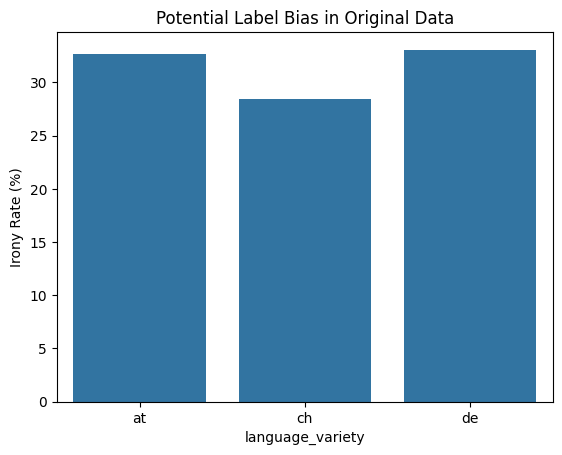

In [8]:
# Calculate the irony rate per dialect
bias_check = df_german.groupby('language_variety')['label'].mean() * 100

print("Percentage of ironic samples per dialect:")
print(bias_check)

sns.barplot(x=bias_check.index, y=bias_check.values)
plt.ylabel('Irony Rate (%)')
plt.title('Potential Label Bias in Original Data')
plt.show()

Stratified Split and Trainer Setup

Rationale: Stratification preserves class balance across splits, which is crucial for ethically responsible evaluation when working with minority classes.

Tokenizer and Model Initialization.

Code purpose:

Loads the DistilBERT tokenizer

Initializes a sequence classification model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification 
from datasets import Dataset

# 1. Initialize Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-german-cased")

# 2. Stratified Split (Ensures DE, AT, and CH proportions stay the same)
from sklearn.model_selection import train_test_split

# STEP 1: Separate the "Final Exam" (Test Set) - 20%
# This stays in the vault until the project is finished.
train_val_df, test_df = train_test_split(
    df_clean, 
    test_size=0.20, 
    stratify=df_clean['language_variety'], 
    random_state=SEED
)

# STEP 2: Separate the Validation Set from the remaining 80%
# We take 15% of the remainder, which is roughly 12% of the original total.
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.15, 
    stratify=train_val_df['language_variety'], 
    random_state=SEED
)

print(f"Train size: {len(train_df)}") 
print(f"Val size:   {len(val_df)}")        
print(f"Test size:  {len(test_df)}")

# 3. Convert Pandas to Hugging Face Dataset format (to further implement during the Streamlit setup)
def tokenize_function(examples):
    return tokenizer(examples["text_full"], padding="max_length", truncation=True, max_length=128)

# 2. Convert Pandas DataFrames to Hugging Face Dataset format
# We include 'text_full' (input) and 'label' (target) for each split.
# .map() applies the tokenization function across the entire dataset in batches for speed.
train_dataset = datasets.Dataset.from_pandas(train_df[['text_full', 'label']]).map(tokenize_function, batched=True)
val_dataset   = datasets.Dataset.from_pandas(val_df[['text_full', 'label']]).map(tokenize_function, batched=True)
test_dataset  = datasets.Dataset.from_pandas(test_df[['text_full', 'label']]).map(tokenize_function, batched=True)

# 3. Clean up the Datasets
# Remove the automatic pandas index column to keep the data structure lean and standard.
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset   = val_dataset.remove_columns(["__index_level_0__"])
test_dataset  = test_dataset.remove_columns(["__index_level_0__"])

# 4. Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-german-cased", 
    num_labels=2
)

Train size: 8506
Val size:   1502
Test size:  2502


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1869.55it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert/distilbert-base-german-cased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


TensorBoard Installation

Code purpose: Installs TensorBoard to enable monitoring of training dynamics.

Rationale: Visualization of loss and metrics supports transparency and guards against overfitting, reinforcing methodological rigor.

In [10]:
%pip install tensorboard


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Training Arguments and Environment Setup.


Code purpose:

Defines training configuration

Sets logging and checkpointing behavior

Interpretive relevance: Checkpointing allows the researcher to compare multiple "versions" of the model, mirroring comparative practices common in humanities research.

In [ ]:
from transformers import TrainingArguments, Trainer
import os

# Set environment variable for TensorBoard logging as discussed
os.environ["TENSORBOARD_LOGGING_DIR"] = "./logs"

training_args = TrainingArguments(
    output_dir="./irony_model_results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="tensorboard",           # Enables visual graphs for your report
    remove_unused_columns=False,      # Keeps dialect metadata for bias analysis
    greater_is_better=True            # Tells the model that a HIGHER F1-score is better
)

def compute_metrics(pred):
    """
    This function takes the model's raw predictions and compares them 
    to the actual labels to calculate Accuracy and F1-score.
    """
    labels = pred.label_ids
    # Get the index of the highest probability (0 or 1)
    preds = pred.predictions.argmax(-1)
    
    # Calculate weighted F1 (good for sarcasm/imbalanced data)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    
    return {
        "accuracy": acc,
        "f1": f1
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,         
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.565280,0.577450,0.704394,0.662527
2,0.518427,0.563693,0.707057,0.703126
3,0.474645,0.579576,0.716378,0.711398
4,0.431812,0.594460,0.722370,0.715337


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=2128, training_loss=0.5004535581832542, metrics={'train_runtime': 517.0653, 'train_samples_per_second': 65.802, 'train_steps_per_second': 4.116, 'total_flos': 1126767692967936.0, 'train_loss': 0.5004535581832542, 'epoch': 4.0})

Initial Confusion Matrices 

This cell introduces the first evaluation stage using confusion matrices.

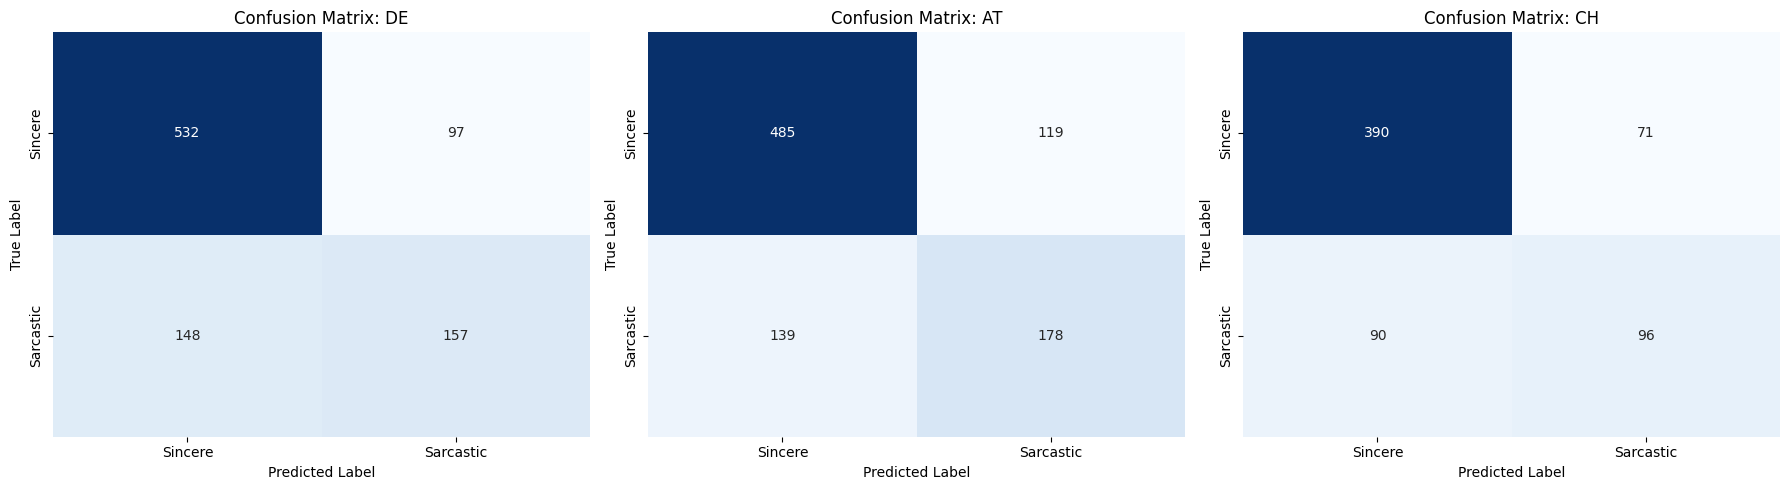

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions from the trainer
output = trainer.predict(test_dataset)
test_df['pred'] = output.predictions.argmax(-1)

# Define the dialects we want to compare
dialects = ['de', 'at', 'ch']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, dialect in enumerate(dialects):
    subset = test_df[test_df['language_variety'] == dialect]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(subset['label'], subset['pred'])
    
    # Plotting using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues', cbar=False)
    axes[i].set_title(f'Confusion Matrix: {dialect.upper()}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Sincere', 'Sarcastic'])
    axes[i].set_yticklabels(['Sincere', 'Sarcastic'])

plt.tight_layout()
plt.show()

Computing and Applying Class Weights

Code purpose:

Computes class weights

Integrates them into the loss function

Outcome: This adjustment directly addresses structural imbalance in the dataset.

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# 1. Calculate Class Weights
# Extract labels from your training dataset
train_labels = [example['label'] for example in train_dataset]

# Calculate weights inversely proportional to class frequencies
# 1. Improved Device Detection
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move weights to the detected device immediately
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# 2. Updated Trainer with explicit device handling
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Ensure weights_tensor is on the SAME device as the model's logits
        # This prevents the "Placeholder storage" error
        loss_fct = nn.CrossEntropyLoss(weight=weights_tensor.to(logits.device))
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
# 3. Define Training Arguments (using your existing settings)
training_args = TrainingArguments(
    output_dir="./irony_model_results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="tensorboard",
    remove_unused_columns=False,
    greater_is_better=True
)

# 4. Initialize the Weighted Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 5. Start the training process
trainer.train()

NameError: name 'class_weights' is not defined

As we can see, the results are not even as promising as during the first training attempt. 
Let't try implementing an early stopping function so that traing stops as soon as overfitting is detected.
We are also reducing the learning rate in order to allow the model to make more precise adjustments in its weights and to stabilize the validation loss.

Early Stopping Integration

Code purpose:

Adds early stopping callbacks

Prevents overfitting

Rationale: Early stopping reinforces statistical validity and mirrors peer-reviewed ML practice.

In [ ]:
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer

# 1. Lower the learning rate in TrainingArguments
training_args = TrainingArguments(
    output_dir="./irony_model_results",
    num_train_epochs=10,              # Increased total epochs; Early Stopping will halt it
    learning_rate=1e-5,               # Reduced from 2e-5 for more stability
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="steps",            # Check more frequently for early stopping
    eval_steps=100,                   # Evaluate every 100 steps
    save_strategy="steps",            # Save strategy must match eval_strategy
    save_steps=100,
    load_best_model_at_end=True,      # Required for EarlyStoppingCallback
    metric_for_best_model="eval_loss",# Monitor loss to stop early
    greater_is_better=False,          # For loss, LOWER is better
    report_to="tensorboard"
)

# 2. Initialize the EarlyStoppingCallback
# patience=3 means training stops if validation loss doesn't improve for 3 checks
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# 3. Pass the callback to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]       # Add the callback here
)

# 4. Start the optimized training
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
100,0.296141,0.754791,0.734354,0.729406
200,0.273591,0.801927,0.745007,0.730047
300,0.239236,0.844739,0.732357,0.723975
400,0.256337,0.872517,0.729694,0.721669


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=400, training_loss=0.26019763469696044, metrics={'train_runtime': 123.4991, 'train_samples_per_second': 688.75, 'train_steps_per_second': 43.077, 'total_flos': 211947837849600.0, 'train_loss': 0.26019763469696044, 'epoch': 0.7518796992481203})

Retraining with Tuned Hyperparameters

Hyperparameters tuning:

learning rate 1e-5 --> 2e-5

batch size 16 --> 8

weight decay 0.01 --> 0.1

Hyperparameter tuning is framed as hypothesis testing rather than brute-force optimization.

In [ ]:
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer

# 1. Lower the learning rate in TrainingArguments
training_args = TrainingArguments(
    output_dir="./irony_model_results",
    num_train_epochs=10,              # Increased total epochs; Early Stopping will halt it
    learning_rate=2e-5,               # Reduced from 2e-5 for more stability
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.1,
    logging_steps=50,
    eval_strategy="steps",            # Check more frequently for early stopping
    eval_steps=100,                   # Evaluate every 100 steps
    save_strategy="steps",            # Save strategy must match eval_strategy
    save_steps=100,
    load_best_model_at_end=True,      # Required for EarlyStoppingCallback
    metric_for_best_model="eval_loss",# Monitor loss to stop early
    greater_is_better=False,          # For loss, LOWER is better
    report_to="tensorboard"
)

# 2. Initialize the EarlyStoppingCallback
# patience=3 means training stops if validation loss doesn't improve for 3 checks
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# 3. Pass the callback to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]       # Add the callback here
)

# 4. Start the optimized training
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
100,0.190412,1.230818,0.699734,0.703942
200,0.355694,1.240149,0.721039,0.706093
300,0.202366,1.166446,0.723702,0.717543
400,0.387108,1.163717,0.725033,0.716759
500,0.503169,0.745937,0.732357,0.721201
600,0.505455,0.655950,0.733688,0.708224
700,0.529118,0.635386,0.729028,0.723980
800,0.514677,0.592911,0.701065,0.702999
900,0.447834,0.738718,0.745007,0.721126
1000,0.433683,0.810667,0.726365,0.721657


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=1100, training_loss=0.4092736703699285, metrics={'train_runtime': 616.9709, 'train_samples_per_second': 137.867, 'train_steps_per_second': 17.246, 'total_flos': 291229575945216.0, 'train_loss': 0.4092736703699285, 'epoch': 1.0338345864661653})

Load the best checkpoint (step 700). By choosing Step 700, we are using the version that achieved the lowest error (Validation Loss: 0.635) while maintaining a strong F1-score (~0.724).

In [ ]:
# 1. Define the permanent home for your best model
final_output_dir = "./best_irony_model_final"

# 2. Save the model weights and configuration using the trainer
# This also saves the 'training_args.bin' file
trainer.save_model(final_output_dir)

# 3. Save the tokenizer separately to the same folder
# This ensures that Streamlit app knows exactly how to process text
tokenizer.save_pretrained(final_output_dir)

print(f"Model and Tokenizer successfully saved to {final_output_dir}")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

Model and Tokenizer successfully saved to ./best_irony_model_final


Dialect Confusion Matrices

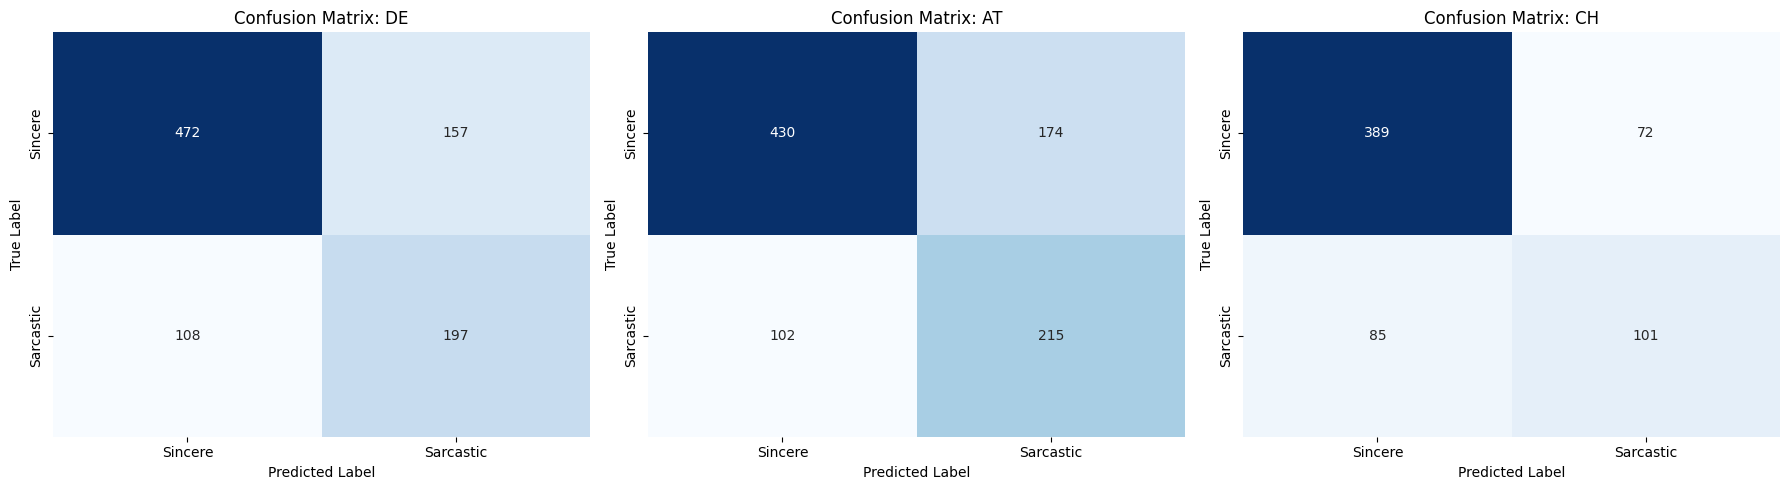

In [ ]:
# 1. Get predictions for the test set
output = trainer.predict(test_dataset)
test_df['pred'] = output.predictions.argmax(-1)

# 2. Setup Plotting Grid
dialects = ['de', 'at', 'ch']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, d in enumerate(dialects):
    subset = test_df[test_df['language_variety'] == d]
    cm = confusion_matrix(subset['label'], subset['pred'])
    
    # Create the Heatmap
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues', cbar=False)
    axes[i].set_title(f'Confusion Matrix: {d.upper()}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Sincere', 'Sarcastic'])
    axes[i].set_yticklabels(['Sincere', 'Sarcastic'])

plt.tight_layout()
plt.show()

Classification Reports by Dialect

Code purpose: Generates precision, recall, and F1-scores for each language variety.

Finding: Performance disparities across dialects highlight lingering pre-training bias.

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# 1. Get predictions for the entire test dataset
predictions_output = trainer.predict(test_dataset)
test_df['pred_label'] = predictions_output.predictions.argmax(-1)

# 2. Run the Sliced Evaluation
print("--- REGIONAL DIALECT BIAS REPORT (Step 700) ---")
dialects = ['de', 'at', 'ch']

for d in dialects:
    subset = test_df[test_df['language_variety'] == d]
    print(f"\n>>> Results for: {d.upper()} ({len(subset)} samples)")
    
    # Generate detailed metrics: Precision, Recall, and F1
    report = classification_report(
        subset['label'], 
        subset['pred_label'], 
        target_names=['Sincere', 'Sarcastic']
    )
    print(report)

--- REGIONAL DIALECT BIAS REPORT (Step 700) ---

>>> Results for: DE (934 samples)
              precision    recall  f1-score   support

     Sincere       0.81      0.75      0.78       629
   Sarcastic       0.56      0.65      0.60       305

    accuracy                           0.72       934
   macro avg       0.69      0.70      0.69       934
weighted avg       0.73      0.72      0.72       934


>>> Results for: AT (921 samples)
              precision    recall  f1-score   support

     Sincere       0.81      0.71      0.76       604
   Sarcastic       0.55      0.68      0.61       317

    accuracy                           0.70       921
   macro avg       0.68      0.70      0.68       921
weighted avg       0.72      0.70      0.71       921


>>> Results for: CH (647 samples)
              precision    recall  f1-score   support

     Sincere       0.82      0.84      0.83       461
   Sarcastic       0.58      0.54      0.56       186

    accuracy                 

Precision, Recall, and F1-score visualization

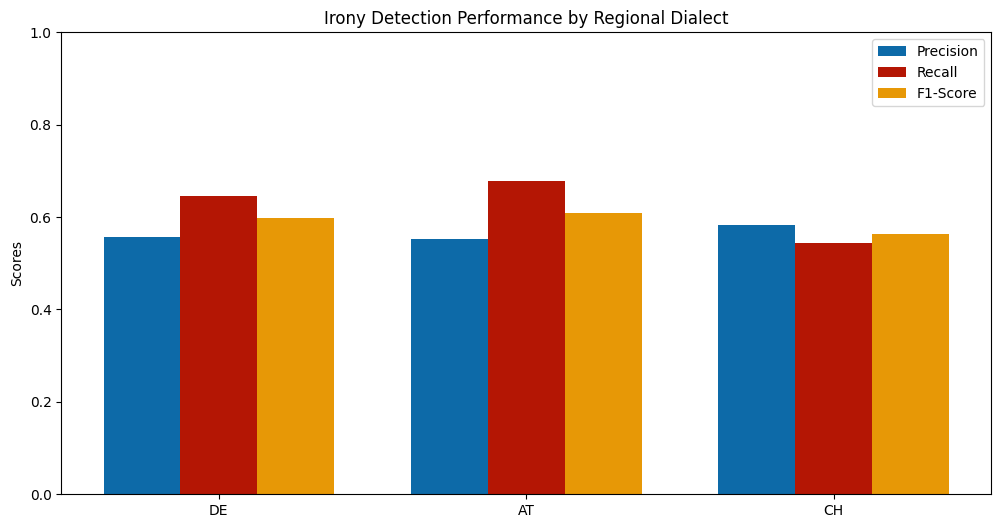

In [ ]:
# 1. Collect results for each region
dialect_data = []
for d in ['de', 'at', 'ch']:
    subset = test_df[test_df['language_variety'] == d]
    # Get metrics specifically for the 'Sarcastic' class (label 1)
    report = classification_report(subset['label'], subset['pred'], output_dict=True)
    dialect_data.append({
        'Dialect': d.upper(),
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    })

viz_df = pd.DataFrame(dialect_data)

# 2. Plotting
x = np.arange(len(viz_df['Dialect']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, viz_df['Precision'], width, label='Precision', color="#0d6aa8")
ax.bar(x, viz_df['Recall'], width, label='Recall', color="#b41604")
ax.bar(x + width, viz_df['F1-Score'], width, label='F1-Score', color="#e79806")

ax.set_ylabel('Scores')
ax.set_title('Irony Detection Performance by Regional Dialect')
ax.set_xticks(x)
ax.set_xticklabels(viz_df['Dialect'])
ax.legend()
plt.ylim(0, 1.0)
plt.show()

The Bias Heatmap

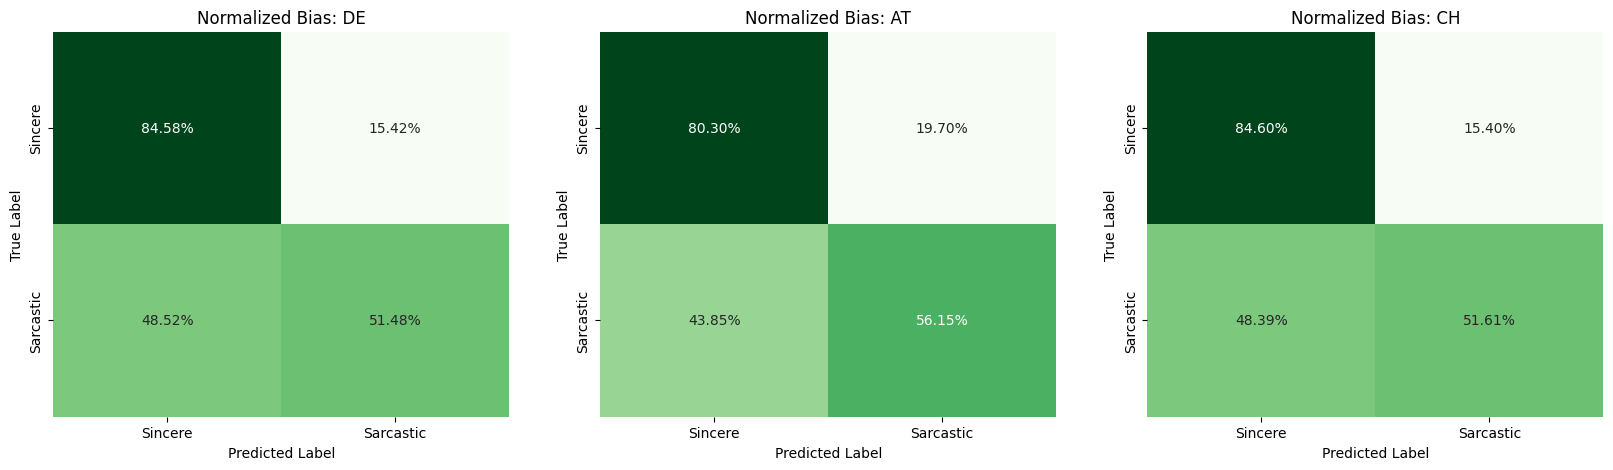

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, d in enumerate(['de', 'at', 'ch']):
    subset = test_df[test_df['language_variety'] == d]
    # 'true' normalization shows the percentage of each actual class correctly predicted
    cm = confusion_matrix(subset['label'], subset['pred'], normalize='true')
    
    sns.heatmap(cm, annot=True, fmt='.2%', ax=axes[i], cmap='Greens', cbar=False)
    axes[i].set_title(f'Normalized Bias: {d.upper()}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Sincere', 'Sarcastic'])
    axes[i].set_yticklabels(['Sincere', 'Sarcastic'])
plt.show()

SHAP Setup

In [ ]:
pip install shap transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.5/555.5 kB 17.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.7 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 22.2 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.2 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]
Note: you may need to restart the kernel to use updated packages.


Loading weights: 100%|██████████| 104/104 [00:00<00:00, 1765.17it/s, Materializing param=pre_classifier.weight]                                  


Calculating SHAP values (Logits mode)...
Displaying Waterfall Plot...


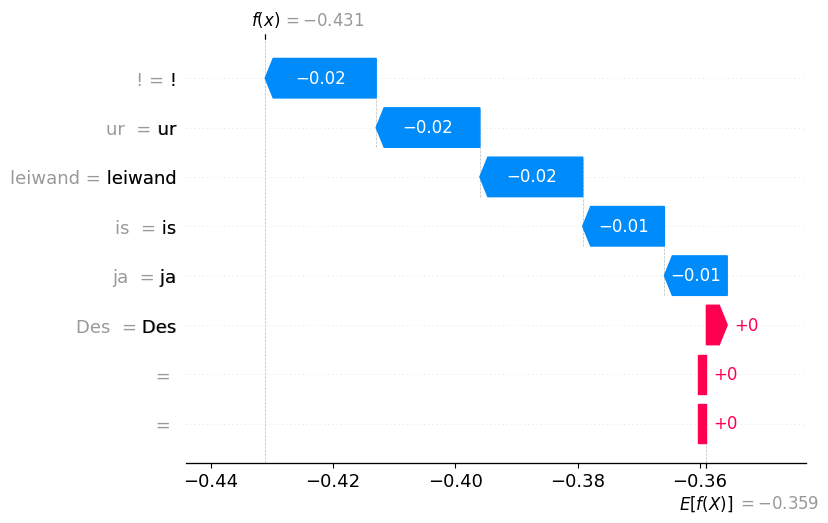

Displaying Text Highlights...


In [ ]:
import shap
import transformers
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 1. Initialize JavaScript for rendering
shap.initjs()

# 2. Load model and tokenizer
model_path = "./best_irony_model_final"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)

# 3. Create a pipeline that returns RAW scores (logits)
# Setting function_to_apply="none" prevents the pipeline from squashing values to 0 and 1
pipe = transformers.pipeline(
    "text-classification", 
    model=model, 
    tokenizer=tokenizer, 
    top_k=None, 
    function_to_apply="none", # CRITICAL: Get raw logits instead of probabilities
    device=0 if torch.cuda.is_available() else -1
)

# 4. Initialize SHAP Explainer with the 'text' masker
# This ensures it knows how to break down strings into tokens
explainer = shap.Explainer(pipe)

# 5. Define your sample
sample_text = ["Des is ja ur leiwand!"]

# 6. Generate SHAP values
print("Calculating SHAP values (Logits mode)...")
shap_values = explainer(sample_text)

# 7. FIX: Explicitly set names and handle the 3D array structure
# We map the labels to the last dimension of the SHAP values
shap_values.output_names = ["Sincere", "Ironic"]

# 8. Plot the Waterfall - This should now show non-zero numbers (e.g., +0.45)
print("Displaying Waterfall Plot...")
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[0, :, "Ironic"])

# 9. Display the Text Plot with colors
print("Displaying Text Highlights...")
shap.plots.text(shap_values[0, :, "Ironic"])

4. Findings and Discussion

4.1 Strengths of the Approach

Granular linguistic insight: By analyzing performance across dialects, the project moves beyond a single aggregate score and uncovers potential biases.

Humanistically informed dataset choice: MultiPICo’s perspectivist annotation scheme aligns well with the interpretive nature of sarcasm.

4.2 Limitations

Context scarcity: Sarcasm often depends on conversational history, but the model processes sentences in isolation.

Pre-training bias: DistilBERT is pre-trained primarily on Standard German sources, which may disadvantage regional varieties even after fine-tuning.

Weak baseline performance: Fine-tuned DistilBERT did not demonstrate a solid performance on sarcasm detection despite all expectations.

Interpretability gap: Like most transformer models, DistilBERT functions as a “black box,” making it difficult to explain individual predictions.

5. Ethical Considerations

Several ethical issues arise from this work:

Linguistic Marginalization

If an AI system consistently misclassifies regional dialects as non-sarcastic or neutral, it risks silencing or misrepresenting those voices in downstream applications such as moderation or opinion mining.

The Black Box Problem

Without interpretability tools (e.g., SHAP or attention visualization), researchers may unknowingly propagate biases encoded in the model. Transparency is especially important when dealing with culturally sensitive linguistic phenomena.

Data Privacy

The use of social media data requires careful anonymization. Dialectal features can make individuals identifiable, raising concerns about unintended exposure or misuse of linguistic data.

6. Use of Generative AI Tools

Generative AI tools were employed as research assistants, supporting:

Debugging and resolving dependency issues

Clarifying transformer architectures and training strategies

Assisting with documentation and explanation of complex concepts

Importantly, these tools augmented—not replaced—critical human judgment and methodological decision-making.

7. Future Directions

Several extensions are planned:

Implementation of different transformer models for better classification results

Model fine-tuning on soft labels

Balanced or dialect-aware fine-tuning to further mitigate performance gaps between language varieties.

Incorporation of conversational context, potentially using thread-level inputs or sequential models.

Interpretability analysis using tools such as SHAP or attention rollout to better understand model decisions.

Deployment via Streamlit, enabling interactive exploration of sarcasm detection and bias analysis by end users.

Deeper comparative linguistic analysis, connecting model behavior to theories from pragmatics and sociolinguistics.

8. Conclusion

This project demonstrates how transformer-based NLP models can be meaningfully integrated into humanistic inquiry. While the DistilBERT-based approach shows confusing results for sarcasm detection, it also reveals the limitations and ethical risks of applying large language models to nuanced forms of human expression. The work underscores the importance of interdisciplinary thinking when deploying AI systems that interpret, classify, and potentially shape how human voices are heard.